In [1]:
from pyrosetta import *
from pyrosetta.rosetta import *
from pyrosetta.rosetta.core.id import *
import numpy as np
import itertools
import scipy
import scipy.linalg
import matplotlib
import matplotlib.pyplot as plt
init()

Found rosetta database at: /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database; using it....
PyRosetta-4 2017 [Rosetta PyRosetta4.Release.python27.ubuntu 2018.11+release.7c7790f7c7790fbb898f8210b54513b9f9c8a927c3e8d7f 2018-03-14T13:19:04] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions.
Created in JHU by Sergey Lyskov and PyRosetta Team.

core.init: Checking for fconfig files in pwd and ./rosetta/flags

core.init: Rosetta version: PyRosetta4.Release.python27.ubuntu r173 2018.11+release.7c7790f 7c7790fbb898f8210b54513b9f9c8a927c3e8d7f http://www.pyrosetta.org 2018-03-14T13:19:04
core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database
core.init: 'RNG device' seed mode, using '/dev/urandom', seed=-372203681 seed_offset=0 real_seed=-372203681
core.init.random: RandomGenerator

In [2]:
pose = rosetta.protocols.recces.pose_setup_turner('aa','')
pmm = PyMOLMover()
pmm.keep_history(True)

core.chemical.GlobalResidueTypeSet: Finished initializing fa_standard residue type set.  Created 603 residue types
core.chemical.GlobalResidueTypeSet: Total time to initialize 0.859375 seconds.
core.scoring.etable: Starting energy table calculation
core.scoring.etable: smooth_etable: changing atr/rep split to bottom of energy well
core.scoring.etable: smooth_etable: spline smoothing lj etables (maxdis = 6)
core.scoring.etable: smooth_etable: spline smoothing solvation etables (max_dis = 6)
core.scoring.etable: Finished calculating energy tables.
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBPoly1D.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBFadeIntervals.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBEval.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/DonStrength.csv
basic.io.database: Database file opened:

In [3]:
def numpy_hessian(x, h):
        
    x_grad = np.gradient(x, h)
    hessian = np.empty((x.ndim, x.ndim) + x.shape, dtype = x.dtype)
    
    for k, grad_k in enumerate(x_grad):
        tmp_grad = np.gradient(grad_k, h)
        for l, grad_kl in enumerate(tmp_grad):
            hessian[k, l, :, :] = grad_kl
            
    return hessian

In [4]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [59]:
def within_360(dof):
    
    diff = dof/360.0
    return dof - 360.0*diff.astype(int)

In [62]:
def is_repeat_minimum(new_dofs, dof_lists):
    
    #dofs_rounded = np.around(new_dofs, decimals=1)
    
    if len(dof_lists) == 0:
        
        return False 
    
    for dof_list in dof_lists:
        
        #dof_list_rounded = np.around(dof_list, decimals=1)

        dof_diff = new_dofs - dof_list
        return np.all(abs(within_360(dof_diff)) > 120.0)
        
        #print truth_vals
        #if truth_vals == False:
        
         #   return False
    
    return True

In [255]:
def possible_chi(base, sugar_pucker, orientation):
    
    if base in ['g','a', 'G', 'A']:

        if sugar_pucker == 'N' or 'north' or 'n':

            if orientation == 'anti' or 'A' or 'a': return [72.4]
            else: return [-110.9, -51.9]

        else:

            if orientation == 'anti' or 'A' or 'a': return [119.0]
            else: return [-56.6]
            
    else:

        if sugar_pucker == 'N' or 'north' or 'n':

            if orientation == 'anti' or 'A' or 'a': return [77.3]
            else: return [-105.7, -47.2]

        else:

            if orientation == 'anti' or 'A' or 'a': return [108.2]
            else: return [-65.0]        
        


In [122]:
def initialiize_pose(seq):
    
    n_residues = len(seq)
    print n_residues
    dof_dict = {}
    
    pose = pyrosetta.rosetta.protocols.recces.pose_setup_turner(seq, '')
    movemap = MoveMap()
    
    for ii in range(n_residues-1):
           
        dof_dict.update({5*ii: TorsionID(ii+1, BB, 5), 5*ii+1: TorsionID(ii+1, BB, 6), 5*ii+2: TorsionID(ii+2, BB, 1), 
                         5*ii+3: TorsionID(ii+2, BB, 2), 5*ii+4: TorsionID(ii+2, BB, 3)})
                        
        movemap.set(TorsionID(5*ii+1, BB, 5), True)
        movemap.set(TorsionID(5*ii+1, BB, 6), True)
        movemap.set(TorsionID(5*ii+2, BB, 1), True)
        movemap.set(TorsionID(5*ii+2, BB, 2), True)
        movemap.set(TorsionID(5*ii+2, BB, 3), True)
    
    for ii in range(n_residues):
    
        dof_dict.update({5*(n_residues-1) + ii: TorsionID(ii+1, CHI, 1)})
        movemap.set(TorsionID(ii+1, CHI, 1), True)
        
    return pose, movemap, dof_dict    
    

In [123]:
def calculate_hessian(pose, scorefxn, dof_dict):
    '''Take a minimized pose and computes the hessian at the base of the corresponding energy well. Returns the hessian matrix
    which may subsequently be diagonalized'''

    minimum = Pose()
    minimum.assign(pose)

    h = 0.1
    h_rad = h*np.pi/180
    E_0 = scorefxn(pose)

    dofs = []

    for val in dof_dict.itervalues(): dofs.append(pose.torsion(val))
    dofs = np.array(dofs)

    hessian = np.zeros((len(dofs), len(dofs)))

    n_pts = int(1/h + 1)
    ind = int(n_pts/2)

    tor_ranges = np.zeros((n_pts, len(dofs)))
    energy = np.zeros((n_pts, n_pts))

    for ii, dof in enumerate(dofs):

        tor_ranges[:, ii] = dof + np.arange(-0.5, 0.5+h, h)

    for pair in list(itertools.combinations(dof_dict.keys(), 2)):

        foo = pair[0]
        bar = pair[1]

        x = tor_ranges[:, foo]
        y = tor_ranges[:, bar]

        for ii, xx in enumerate(x):

            pose.set_torsion(dof_dict[pair[0]], xx)

            for jj, yy in enumerate(y):

                pose.set_torsion(dof_dict[pair[1]], yy)

                energy[ii, jj] = scorefxn(pose)

                pose.set_torsion(dof_dict[pair[1]], dofs[bar])

            pose.set_torsion(dof_dict[pair[0]], dofs[foo])

        hess = numpy_hessian(energy, h_rad)

        d2E_dx2 =  hess[0,0,:,:]
        d2E_dy2 =  hess[1,1,:,:]
        d2E_dxdy = hess[0,1,:,:]

        if hessian[foo, foo] == 0:

            hessian[foo, foo] = d2E_dx2[ind, ind]

        if hessian[bar, bar] == 0:

            hessian[bar, bar] = d2E_dy2[ind, ind]

        hessian[foo, bar] = d2E_dxdy[ind, ind]
        hessian[bar, foo] = d2E_dxdy[ind, ind]
        
    return hessian


In [124]:
def mode_scan(pose, dofs, dof_dict, scorefxn, mode, kT = 1.0, h = 0.5):
    
    temp = Pose()
    temp.assign(pose)
    
    E_0 = scorefxn(pose)
    E = E_0
    inc = 0
    result = 0.0
    
    max_inc = int(60/h)

    while inc < max_inc:
        
        inc += 1
        result += 0.5*np.exp(-(E-E_0)/kT)
        dofs_new = dofs + (60.0)*inc/float(max_inc)*mode
        
        for key, val in enumerate(dofs_new):

            temp.set_torsion(dof_dict[key], val)
        
        E = scorefxn(temp)
        result += 0.5*np.exp(-(E-E_0)/kT)

    # Reinitialize pose
    temp.assign(pose)
    inc = 0
    E = E_0
    
    while inc < max_inc:
        
        inc += 1
        
        result += 0.5*np.exp(-(E-E_0)/kT)
        dofs_new = dofs + 60.0*inc/float(max_inc)*mode
        
        for key, val in enumerate(dofs_new):
    
            temp.set_torsion(dof_dict[key], val)
        
        E  = scorefxn(temp)
        result += 0.5*np.exp(-(E-E_0)/kT)
        
    result *= h*np.pi/180.0
    return result


In [125]:
fuck = core.scoring.ScoreFunctionFactory.create_score_function('stepwise/rna/turner.wts')
scorefxn = fuck
'''
#rna_hires = core.scoring.ScoreFunctionFactory.create_score_function('rna/denovo/rna_hires_recces')
#rna_hires.set_weight(core.scoring.geom_sol, 0)
#rna_hires.set_weight(core.scoring.ch_bond, 0)
#rna_hires.set_weight(core.scoring.rna_sugar_close, 0)
rna_hires.set_weight(core.scoring.hbond_lr_bb_sc, 0.)
rna_hires.set_weight(core.scoring.hbond_sr_bb_sc, 0.)
rna_hires.set_weight(core.scoring.hbond_sc, 0.)
rna_hires.set_weight(core.scoring.atom_pair_constraint, 0.)
rna_hires.set_weight(core.scoring.fa_atr,0.73)
rna_hires.set_weight(core.scoring.fa_rep, 0.10)
rna_hires.set_weight(core.scoring.fa_intra_rep, 0.0071) 
rna_hires.set_weight(core.scoring.lk_nonpolar, 0.25) 
rna_hires.set_weight(core.scoring.fa_elec_rna_phos_phos, 4.54) 
rna_hires.set_weight(core.scoring.rna_torsion, 4.26) 
rna_hires.set_weight(core.scoring.stack_elec, 1.54) 
rna_hires.set_weight(core.scoring.hbond_sc, 2.46)
rna_hires.energy_method_options().rna_options().torsion_potential('RNA11_based_new')
rna_hires.energy_method_options().hb_options().
scorefxn = rna_hires
'''
print scorefxn

ScoreFunction::show():
weights: (fa_atr 0.73) (fa_rep 0.1) (fa_intra_rep 0.0071) (lk_nonpolar 0.25) (fa_elec_rna_phos_phos 4.54) (rna_torsion 4.26) (stack_elec 1.54) (hbond_sc 2.46)
energy_method_options: EnergyMethodOptions::show: aa_composition_setup_files: 
EnergyMethodOptions::show: netcharge_setup_files: 
EnergyMethodOptions::show: aspartimide_penalty_value: 25
EnergyMethodOptions::show: etable_type: FA_STANDARD_DEFAULT
analytic_etable_evaluation: 1
EnergyMethodOptions::show: method_weights: free_res
EnergyMethodOptions::show: unfolded_energies_type: UNFOLDED_SCORE12
EnergyMethodOptions::show: split_unfolded_label_type: SPLIT_UNFOLDED_MM
EnergyMethodOptions::show: split_unfolded_value_type: SPLIT_UNFOLDED_BOLTZ
EnergyMethodOptions::show: atom_vdw_atom_type_set_name: centroid
EnergyMethodOptions::show: exclude_protein_protein_fa_elec: false
EnergyMethodOptions::show: exclude_RNA_RNA_fa_elec: false
EnergyMethodOptions::show: exclude_monomer_fa_elec: false
EnergyMethodOptions::show: 

In [243]:
seq = 'gg'
n = len(seq)
mu_list = []
pmm = PyMOLMover()
pmm.keep_history(True)
E_list = []
i = 0
dof_lists = []

In [244]:
# Code for a purine stacked on a purine

for delta in [81.195, 145.521]:
    
    dof_lists = []
    
    for alpha in [-64.3, 66.7, 156.6]:
        
        pose, movemap, dof_dict = initialiize_pose(seq)
        
        pose.set_torsion(TorsionID(1, BB, 4), delta)
    
        if delta == 81.195:

                pose.set_torsion(TorsionID(1, CHI, 2), 35.870)
                pose.set_torsion(TorsionID(1, CHI, 3), 94.856)
                possible_chi = [-110.9, -51.9, 72.4]
                possible_eps = [-150.4, 16.8, 76.2]

        #C2'-endo
        else:

            possible_chi = [-56.6, 119.0]
            possible_eps = [-97.4, 0, 75.2]

            for ii in range(len(seq)-1):

                pose.set_torsion(TorsionID(ii+1, CHI, 2), -34.825)
                pose.set_torsion(TorsionID(ii+1, CHI, 3), 155.987)

    
        print dof_dict
        # These will set the terminal base pair to C2'-endo (south)
        pose.set_torsion(TorsionID(n, BB, 4), 145.521)
        pose.set_torsion(TorsionID(n, CHI, 2), -34.825)
        pose.set_torsion(TorsionID(n, CHI, 3), 155.978)
                
        if alpha == -64.3: possible_zeta = [-71.8, 167.55]
        elif alpha == 66.7: possible_zeta = [-131.6, 79.0]
        else: possible_zeta = [-69.5, 56.5]
        
        
        torsion_lists = itertools.product(possible_eps, possible_zeta, [alpha], [177.3], [-62.9, 53.5, 175.8], possible_chi, 
                                          [-56.6, 119.0])
        
        
        
        for torsion_list in list(torsion_lists):
            
            pose.set_torsion(TorsionID(1, BB, 5), torsion_list[0])
            pose.set_torsion(TorsionID(1, BB, 5), torsion_list[1])
            pose.set_torsion(TorsionID(2, BB, 1), torsion_list[2])
            pose.set_torsion(TorsionID(2, BB, 2), torsion_list[3])
            pose.set_torsion(TorsionID(2, BB, 3), torsion_list[4])
            pose.set_torsion(TorsionID(1, CHI, 1), torsion_list[5])
            pose.set_torsion(TorsionID(2, CHI, 1), torsion_list[6])
        
            minmover = rosetta.protocols.minimization_packing.MinMover(movemap, scorefxn, 'lbfgs_armijo', 1.0e-7, True)
            minmover.max_iter(1000000)
            minmover.min_options().use_nblist(True)
            minmover.min_options().nblist_auto_update(True)
            minmover.apply(pose)
            pmm.apply(pose)

            E_min = scorefxn(pose)
            
            
            minimum = Pose()
            minimum.assign(pose)
            
            dofs = []

            for val in dof_dict.itervalues(): dofs.append(pose.torsion(val))
            dofs = np.array(dofs)

            if is_repeat_minimum(dofs, dof_lists):
                
                continue
                
            dof_lists.append(dofs)
                    
                    
            hessian = calculate_hessian(pose, scorefxn, dof_dict)
            w,v = scipy.linalg.eigh(hessian)

            if not np.all(w > 0.):
                continue

            E_list.append(E_min)
            Z = 1

            print E_min
            for kk, K in enumerate(w):

                Z *= mode_scan(pose, dofs, dof_dict, scorefxn, v[:,kk])

            #mu_list.append(scorefxn(minimum) - 0.6163*np.log(Z))
            mu_list = np.append(mu_list, scorefxn(minimum)- 0.6163*(np.log(Z) - 7*np.log(2*np.pi/3)))

'''
# South, anti
pose.set_torsion(TorsionID(1, BB, 4), 145.4)
pose.set_torsion(TorsionID(1, BB, 5), -97.4)
pose.set_torsion(TorsionID(1, CHI, 1), -56.6)
pose.set_torsion(TorsionID(1, CHI, 2), -37.2)
pose.set_torsion(TorsionID(1, CHI, 3), 155.5)
pose.set_torsion(TorsionID(2, BB, 1), 66.7)
pose.set_torsion(TorsionID(2, BB, 3), -62.9)
pose.set_torsion(TorsionID(2, BB, 4), 145.4)
pose.set_torsion(TorsionID(2, CHI, 1), -56.6)
pose.set_torsion(TorsionID(2, CHI, 2), -37.2)
pose.set_torsion(TorsionID(2, CHI, 3), 155.5)
'''

2
{0: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f74ecc8c6c0>, 1: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f74ecc8c378>, 2: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f74ecc8c618>, 3: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f74ecc8c3e8>, 4: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f74ecc8c650>, 5: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f74ecc8c570>, 6: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f74ecc8ca78>}
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-06 Deriv= -1.14039e-05 Finite Diff= 1.48572e-05
5.78487347957
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-06 Deriv= -0.00026879 Finite Diff= 3.73484e-06
4.77659608118
2.44183113275
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-06 Deriv= -0.000101737 Finite Diff= 6.02333e-05
2.26189305575
-4.89988837994
-6.98446976978
2.57038030651
-1.25777244603
4.56946591899
0.173506431183
core.optimization.LineMinimi

0.141947503617
6.08617178937
7.91056206903
3.86894663835
5.8175465748
-2.16941543242
-0.323708500317
15.342567325
14.4289597861
13.9502459603
12.9384238796
7.21057860191
6.20156855888
15.5969597006
12.4734797358
14.1054300797
10.9828146192
7.37064813216
4.24580916723
13.6962530362
12.3188536051
11.7286173906
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-06 Deriv= -3.85527e-07 Finite Diff= 2.61213e-06
6.12187425398
5.60746326924
4.12593734363
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-06 Deriv= -0.000999051 Finite Diff= 0.00189972
6.86700817227
9.64852753172
5.77924996668
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-06 Deriv= -2.35452e-05 Finite Diff= 3.34672e-05
3.90640231749
-2.95812563122
-2.48513544432
11.6916209411
8.4230398951
8.07716389547
4.8619061741
2.66056187168
-6.67104653377
6.08616094048
7.91055490168
3.86895895846
5.81401636822
-2.16941304802
-0.323708231701
15.3425660821
14.4296786639
13.94861

-2.75218409299
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-06 Deriv= -4.3967e-05 Finite Diff= 7.1638e-05
-6.20246542262
17.3374264431
15.0649146264
15.8511016265
13.5786520934
9.10991446887
6.83740405449
14.4424500431
12.3628576242
12.9249796692
10.8822746715
6.2188350571
4.13864421788
7.43381432019
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 1.90735e-06 Deriv= -0.000377707 Finite Diff= -3.41628e-05
7.65773201541
9.63341478041
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-06 Deriv= -0.000275483 Finite Diff= -2.39625e-05
8.41925107404
2.67443754295
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 1.90735e-06 Deriv= -3.37699e-05 Finite Diff= 3.91218e-05
2.01174802441
2
{0: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f74ecc8cab0>, 1: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f74ecc8c768>, 2: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f74ecc8c6f8>, 3: <pyrosetta.rosetta.core.id.Torsion

-8.17775536189
11.3027236947
9.02892122983
8.80861271706
6.53240755869
10.0035547058
6.33913471918
7.21140199021
3.61900370941
3.4843447884
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-06 Deriv= -2.55473e-07 Finite Diff= 1.66346e-06
1.61857363567
599.001698895
-0.625721210914
7.02648834783
4.75417939121
4.75846662605
2.48616554561
1.32904088785
0.102323179012
-0.922284280443
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 1.90735e-06 Deriv= -2.66982e-07 Finite Diff= 2.468e-08
-2.03463723687
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 4.76837e-07 Deriv= -7.65836e-05 Finite Diff= 0.000345888
-2.75567081413
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-06 Deriv= -0.000944755 Finite Diff= 0.000414543
-5.71857626243
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-06 Deriv= -0.000952414 Finite Diff= 3.3487e-05
-1.99655261452
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step

'\n# South, anti\npose.set_torsion(TorsionID(1, BB, 4), 145.4)\npose.set_torsion(TorsionID(1, BB, 5), -97.4)\npose.set_torsion(TorsionID(1, CHI, 1), -56.6)\npose.set_torsion(TorsionID(1, CHI, 2), -37.2)\npose.set_torsion(TorsionID(1, CHI, 3), 155.5)\npose.set_torsion(TorsionID(2, BB, 1), 66.7)\npose.set_torsion(TorsionID(2, BB, 3), -62.9)\npose.set_torsion(TorsionID(2, BB, 4), 145.4)\npose.set_torsion(TorsionID(2, CHI, 1), -56.6)\npose.set_torsion(TorsionID(2, CHI, 2), -37.2)\npose.set_torsion(TorsionID(2, CHI, 3), 155.5)\n'

In [245]:
import scipy.special
print len(mu_list)
mu_list = np.array(mu_list)
print 0.6163*(-scipy.special.logsumexp(-mu_list[:]/0.6163))#  - 7*np.log(2*np.pi/3) - 2*np.log(2))

527
-2.5708837065464945


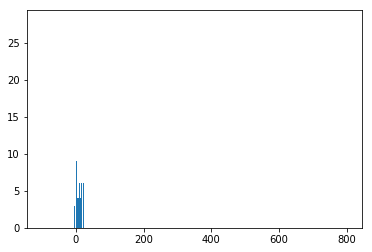

In [214]:
hist = plt.hist(E_list,bins=9000,range=(-100,800))

-10.0581193901
Inferring sequence from directory name:  ga
applying phase space volume for single strand with length  2


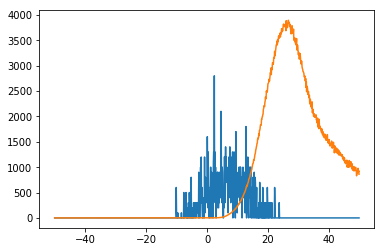

In [215]:
from scipy.special import logsumexp
from recces.data import SingleHistSimulation
from recces.util import torsion_volume
print min(E_list)
sim = SingleHistSimulation('./../recces_rosetta/results/ga/ST/')
plt.plot(hist[1][500:1500], hist[0][500:1500]*100)#*np.exp(-hist[1][500:1500])/75)
plt.plot(sim._dos_scores[500:1500], sim._dos[500:1500])#*np.exp(-sim._dos_scores[500:1500]))

In [216]:
pose = protocols.recces.pose_setup_turner('ga','')

minmover.apply(pose)
pmm.apply(pose)
hessian = calculate_hessian(huh, scorefxn, dof_dict)
print scorefxn(huh)
dofs = []
for val in dof_dict.itervalues(): dofs.append(pose.torsion(val))
dofs = np.array(dofs)

-10.1165823616


In [217]:
w, v = scipy.linalg.eigh(hessian)
obs = protocols.moves.AddPyMOLObserver(pose, True)
pose.assign(minimum)
E_min = scorefxn(huh)
print E_min

-10.1165823616


In [218]:
print scorefxn(huh) - 0.5*len(w)*np.log(2*np.pi) + 0.5*np.log(scipy.linalg.det(hessian))

-1.2313832816101051


In [50]:
import scipy.integrate

Z = 1

#pose.assign(minimum)
#E_min = scorefxn(minimum)
kT = 1.0
fig = plt.figure()
for kk in range(len(w)):
 
    mode = v[:,kk]
    h = range(-30,31,1)
    fuck = h[:-1]
    fuck.reverse()
    h = h+fuck
    h = np.array(h)
    h_plot = h*np.pi/180

    bar = []


    for hh in h:

        dofs_new = dofs+hh*mode

        for jj, dof in enumerate(dofs_new):

            pose.set_torsion(dof_dict[jj], dof)

        bar.append((scorefxn(pose)-E_min)/kT)

    
    Z *= np.trapz(np.exp(-np.array(bar)), dx = np.pi/180.)
    #np.array(bar) 
    #pose.assign(minimum)
    #plt.subplot(3, 4, kk+1)
    #plt.plot(h, np.exp(-np.array(bar)))
    #plt.plot(h, np.exp(-0.5*K*h_plot**2/kT))
    #plt.xlabel('Displacement along normal coordinate (degrees)')
    #plt.ylabel('exp(-(E-E0)/kT)')

<Figure size 432x288 with 0 Axes>

In [51]:
print scorefxn(huh) - np.log(Z)

-9.65191278688959


In [281]:
print min(E_list)

-11.3144552565


In [74]:
print pose.epsilon(1)

-147.213383076


In [446]:
pose = protocols.recces.pose_setup_turner('ga','')
print pose.epsilon(1)

-150.17


In [456]:
minmover.tolerance(1e-7)
minmover.max_iter(100000)
minmover.apply(pose)


In [457]:
pmm.apply(pose)

In [ ]:
print dof_dict
from scipy.special import gamma

In [54]:
hessian = calculate_hessian(pose, scorefxn, dof_dict)
print np.linalg.det(hessian)

116552482.28438939


In [55]:
print scorefxn(pose) + 0.5*np.log(np.linalg.det(hessian)) - 3.5*np.log(2*np.pi)
E_min = scorefxn(huh)
print E_min

3.357066743696679
-10.1165823616


In [56]:
matt_guess = lambda E: (2.0*np.pi)**(len(w)/2)*(E-E_min)**(len(w)/2 - 1)/gamma(len(w)/2)/np.sqrt(np.linalg.det(hessian))*np.heaviside(E-E_min, 0.5)#2*(2*np.pi)**((len(w)-1)/2)*(2*(E-E_min))**(len(w)/2-1)/scipy.misc.factorial2(len(w)-2)/np.sqrt(np.linalg.det(hessian))*np.heaviside(E-E_min,0.5)

In [57]:
plt.plot(hist[1][500:1500], matt_guess(hist[1][500:1500])*np.exp(-hist[1][500:1500]))
plt.plot(sim._dos_scores[500:1500], np.exp(-sim._dos_scores[500:1500])*sim._dos[500:1500]*3)

NameError: global name 'gamma' is not defined

In [282]:
print pose.zeta(1)

-77.3430805169


In [173]:
pose = rosetta.protocols.recces.pose_setup_turner('gg',''

In [174]:
print pose.torsion(TorsionID(2, BB, 4)), pose.torsion(TorsionID(1, CHI, 2))

81.1757667609 35.8538883447


In [482]:
scorefxn(pose)

-11.567710305815666

In [487]:
print pose

PDB file name: ./../../OneDrive/Documents/fuck.pdb
Total residues:2
Sequence: gg
Fold tree:
FOLD_TREE  EDGE 1 2 -1 


In [490]:
print pose.alpha(2), pose.beta(2), pose.gamma(2), pose.delta(1), pose.epsilon(1), pose.zeta(1)

-63.5353344862 165.161840316 56.4252019168 81.1556157339 -144.424366643 -67.563117667


In [39]:
huh = pose_from_file('./../recces_rosetta/results/min.pdb')
print huh.torsion(TorsionID(1, CHI, 2)), huh.torsion(TorsionID(1, CHI, 3))

core.import_pose.import_pose: File './../recces_rosetta/results/min.pdb' automatically determined to be of type PDB
35.8338936386 94.9245357198


In [35]:
print 
pmm.apply(huh)
print huh.epsilon(1), huh.zeta(1), huh.alpha(2), huh.beta(2), huh.gamma(1), huh.delta(2), huh.chi(1), huh.chi(2)


-150.267856926 -74.0033012268 -60.799044942 161.123642633 55.558354 81.1164418812 76.4079790151 77.2593548418


In [496]:
print huh.alpha(2), huh.beta(2), huh.gamma(2), huh.epsilon(1), huh.zeta(1)

-62.6200774422 166.019239581 55.7637044788 -146.782226207 -66.7916732357


In [497]:
scorefxn(huh)

-11.276060713948727

In [148]:
pose.set_ring_conformation('north')

TypeError: set_ring_conformation(): incompatible function arguments. The following argument types are supported:
    1. (self: pyrosetta.rosetta.core.pose.Pose, seqpos: int, ring_num: int, conformer: pyrosetta.rosetta.core.chemical.rings.RingConformer) -> None

Invoked with: <pyrosetta.rosetta.core.pose.Pose object at 0x7f74f35570a0>, 'north'

In [158]:
print pose.

AttributeError: 'pyrosetta.rosetta.core.pose.Pose' object has no attribute 'pucker_state'

In [230]:
pose = pose_from_file('./../../das-lab/recces_rosetta/results/ag/ST/ST_637000.pdb')

core.import_pose.import_pose: File './../../das-lab/recces_rosetta/results/ag/ST/ST_38000.pdb' automatically determined to be of type PDB


In [231]:
print pose.delta(1), pose.torsion(TorsionID(1, CHI, 2)), pose.torsion(TorsionID(1, CHI, 3))
print pose.delta(2), pose.torsion(TorsionID(2, CHI, 2)), pose.torsion(TorsionID(2, CHI, 3))

81.1337877971 35.8338936386 94.9245357198
145.62371869 -34.8376957519 155.917321435


In [233]:
# ag/ST/367000, 38000

# C2'-endo
print 145.521118169, -34.8252844774, 155.978251202

# C3'-endo
print 81.1950530464, 35.8703398534, 94.8555221911

145.521118169 -34.8252844774 155.978251202
81.1950530464 35.8703398534 94.8555221911


In [250]:
pose = protocols.recces.pose_setup_turner('gg','')

In [251]:
pmm.apply(pose)
pose.set_torsion(TorsionID(1, BB, 4), 145.5)
pose.set_torsion(TorsionID(1, CHI, 2), -34.8)
pose.set_torsion(TorsionID(1, CHI, 3), 155.98)

In [252]:
pmm.apply(pose)

In [253]:
pose.set_chi(1, -56.6)

In [254]:
pmm.apply(pose)